In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

#my functions
from utils import load_data

#go to working directory
work_dir='/mnt/Data1/ribli/mhc/'
os.chdir(work_dir)

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)
/mnt/Data1/ribli/tools/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
x,y=load_data(hla_representation='one-hot',seq_representation='one-hot')

Reading from file...
Creating representation...
Using  83751 data points
Done, It took: 2.25845909119 s


In [3]:
#make train, test and validation split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [4]:
#create a very simple deepish model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse', optimizer='adam')


validation_split=0.1
patience=1
nb_epoch=100

#callbacks
best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
early_stop=EarlyStopping(patience=patience,verbose=1)


#train it
callb_hist=model.fit(X_train,y_train,nb_epoch = nb_epoch,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    
#predict
model.load_weights('best_model')
y_pred_test=model.predict(X_test).ravel()

Train on 67837 samples, validate on 7538 samples
Epoch 1/100
67837/67837 [==============================] - 3s - loss: 1.3715 - val_loss: 1.0875
Epoch 00000: val_loss improved from inf to 1.08753, saving model to best_model
Epoch 2/100
67837/67837 [==============================] - 4s - loss: 0.8908 - val_loss: 0.8643
Epoch 00001: val_loss improved from 1.08753 to 0.86433, saving model to best_model
Epoch 3/100
67837/67837 [==============================] - 3s - loss: 0.6794 - val_loss: 0.8130
Epoch 00002: val_loss improved from 0.86433 to 0.81296, saving model to best_model
Epoch 4/100
67837/67837 [==============================] - 3s - loss: 0.5699 - val_loss: 0.8036
Epoch 00003: val_loss improved from 0.81296 to 0.80359, saving model to best_model
Epoch 5/100
67837/67837 [==============================] - 3s - loss: 0.4857 - val_loss: 0.8063
Epoch 00004: val_loss did not improve
Epoch 6/100
67837/67837 [==============================] - 3s - loss: 0.4230 - val_loss: 0.7554
Epoch 000

Correlation: (0.76731995060068281, 0.0)


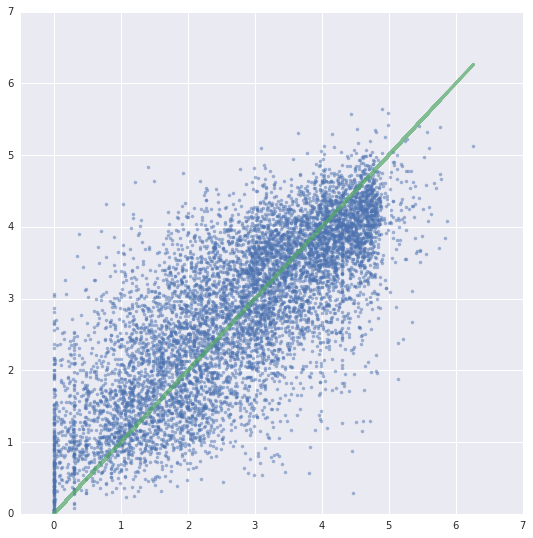

In [5]:
# check correlation
plt.figure(figsize=(9,9))
plt.plot(y_test,y_pred_test,'.',alpha=0.5)
plt.plot(y_test,y_test,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y_test,y_pred_test)

### Error depending on the length of peptid

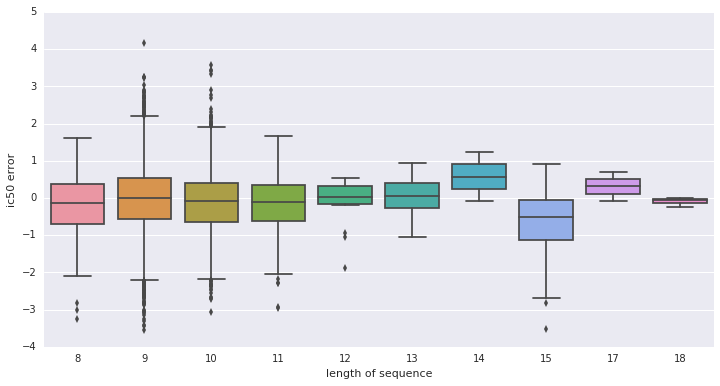

In [6]:
leng=X_test[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y_test-y_pred_test)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')